# Lab 8: Ships in Satellite Imagery

You will build & train an object detector using the Historgram of Gradients (HOG) Descriptor as the representation for the image patches. We will use this object detector to solve the problem of idenifying ships in satellite imagry using the dataset https://www.kaggle.com/rhammell/ships-in-satellite-imagery.  This dataset consists of images of ships and images of NOT ships and is therefore a binary classification problem. The NOT ship categroies include partial ships and also linear image features such as roads, jetty's etc that may be confused with ships.   


Learning Outcomes:
This assignment demonstrates that classical image processing techniques may be used in preference to deep learning for certain applications. Particularly those that are limited in computational power or require fast execution.

**This lab uses a kaggle dataset**. Please read the [PDF](https://github.com/tonyscan6003/etivities/blob/main/kaggle_data_instructions.pdf) detailing how to setup your PC so that you can use a kaggle dataset within Colab. This assigment contains all the code necessary to read the downloaded kaggle files and create image and label arrays with test and train splits.

![Ships in Satellite imagery](https://i.imgur.com/tLsSoTz.png)



Taks: In this assignment you will create a class  `HogObjDet` to perform object detection. We intially train a Support Vector Machine classifer on 80 x 80 patches of the image that have been converted to the HOG representation. We then use the trained classifer as part of a sliding window detector, that is applied to larger image patch by patch stepwise around the image.

**HOG Descriptor**

In order to apply the HOG descriptor on each of the image patches during training we can use the `feature.hog` method from [skimage](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html).

As in the pedestran detection case we will use the default HOG parameters e.g. 9 orientations in each histogram, 8 x 8 pixels in the cell and 2 x 2 cells per block are used. The size of the detector window in this case is chosen to be the same as the image size = 80 x 80 pixels. We can calculate the length of the resulting HOG vector by determining the Number of orientations (9) x size of block (16) x number of overlapping blocks in x-direction(9) x number blocks in y-direction(9). (We assumed the blocks overlap 50% in this calculation)The arguments for the feature.hog method are passed into the class initialisation as seen in the skeleton code below.


**SVM Classifier**

In order to classify the training data we use the [sklearn support vector machine](https://scikit-learn.org/stable/modules/svm.html) object and methods. You can create separate methods `train_classifier` and `test_classifier` to train and test the classifer. The SVM object can also be created as instances within your class. The train_classifier method has arguments for X_train,y_train, while the test_classifier method will only have X_test as an argument.

**Sliding Window Detector**

You can include the method `sliding_window` in your class. This method as the name suggests will run the detector (i.e. trained classifier) over a large image and each 80 x 80 patch is classified to see if it includes a ship or not (remember to convert the image patch to the descriptor)


> The method outputs the array m x 4, where m is the number of bounding boxes detected.


*Step Size*
> The sliding window which is the same size as our training images `n` = 80, should be stepped around the image according to the value of the input argument `step_size` in `sliding_window` (similar to stride in convolution). Larger step values may cause an object to be missed, however using a larger step size will increase the speed of execution which is useful to debug your algorithm. When a smaller step size is used, multiple detections of the same object can occur.

*Coordinate Systems*

> The greyscale input image that we are applying our sliding window detector to is a matrix. The elements of this matrix are accessed as (row,column). In order to successfully plot the bouding box using OpenCV rectangle commands, the bounding boxes must be output in a format [x1,y1,x2,y2] where x1,y1 correspond to the top left hand side corner of the bouding box and x2,y2 the bottom right corner. Thus the x coordinate of the bounding box corresponds to the column of the matrix and the y coordinate the rows. The origin (0,0) in the coordinate system used by OpenCV is the top left of the image.

*Non Maximal Supression*

>  We can use the `non_max_supression` function from the `imutils` package to remove overlapping detections. (This is already implemented in the code cell below that displays the bouding boxes you find)  

*Image Pyramid*

> We will not include a image pyramid in our object detector. As the test scene images are taken from fixed position satellite images similar to the training patches, there is no need to adjust the scale of the image.










# Dowload Kaggle Dataset.
The following code cells will download the kaggle ship-in-satellite-imagery dataset and unzip the file. (Ensure you have a valid kaggle API token stored on your PC as described in the PDF.)

**Comment out all code cells in this section below before submission to codegrade**

In [1]:

#! pip install -q kaggle==1.5.6
#! pip install -q kaggle
#from google.colab import files
#files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashik02","key":"f48bd4704e02fc92c2d60ffcd9e15231"}'}

In [ ]:
# Use this only if have problems with stale .json file
#!rm kaggle.json
#!rm ~/.kaggle/kaggle.*

In [2]:

#Choose the kaggle.json file that you downloaded
#! mkdir ~/.kaggle
#Make directory named kaggle and copy kaggle.json file there.
#! cp kaggle.json ~/.kaggle/
#Change the permissions of the file.
#! chmod 600 ~/.kaggle/kaggle.json

# Load dataset
#! kaggle datasets download rhammell/ships-in-satellite-imagery

#!unzip ships-in-satellite-imagery.zip > /dev/null


Dataset URL: https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery
License(s): CC-BY-SA-4.0
 99% 183M/185M [00:00<00:00, 193MB/s]
100% 185M/185M [00:00<00:00, 231MB/s]


# Import packages & Read Data
Read data from unzipped downloaded files and create the Training and Test sets.

In [3]:

from skimage import feature
from skimage import exposure
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pickle
import glob
import urllib.request
import cv2
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression
from tqdm import tqdm


In [4]:


class ImageDataset:
    def __init__(self, pos_img_list, neg_img_list, image_size=80, n_pts=4000, train_ratio=0.7):
        self.image_size = image_size
        self.n_pts = n_pts
        self.train_ratio = train_ratio

        # Load and process images
        self.pos_images = self._read_images(pos_img_list)
        self.neg_images = self._read_images(neg_img_list)

        # Create labels
        y_pos = np.ones(len(pos_img_list))
        y_neg = np.zeros(len(neg_img_list))

        # Combine images and labels
        self.images = np.concatenate((self.pos_images[:1000], self.neg_images[:3000]))
        self.labels = np.append(y_pos[:1000], y_neg[:3000])

        # Split into train and test sets
        self._split_data()

    def _read_images(self, img_list):
        data = []
        for img_path in img_list:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            data.append(img.flatten())
        return np.array(data)

    def _split_data(self):
        n_train = int(self.train_ratio * self.n_pts)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.images, self.labels, train_size=n_train, random_state=0, stratify=self.labels
        )

    def get_train_test_split(self):
        return self.X_train, self.X_test, self.y_train, self.y_test

    def plot_examples(self, num_examples=10, from_test=False):
        X = self.X_test if from_test else self.X_train
        y = self.y_test if from_test else self.y_train

        fig, axarr = plt.subplots(1, num_examples, figsize=(15, 3))
        for i in range(num_examples):
            axarr[i].imshow(X[i].reshape(self.image_size, self.image_size), cmap='gray')
            axarr[i].axis('off')
            axarr[i].set_title(f"Label: {int(y[i])}")
        plt.tight_layout()
        plt.show()

    def plot_test_examples(self,X_test,y_test,y_pred,n_plots=30):
        '''
          X_test: dataset of test images
          y_test: true labels
          y_pred: predicted labels
        '''
        fig = plt.figure(figsize=(20, 15))
        for i in range(100):
           ax = fig.add_subplot(10, 20, i + 1, xticks=[], yticks=[])
           ax.imshow( np.reshape(X_test[i,0:patch_size*patch_size], (patch_size, patch_size)) ,'gray')
           color = ('black' if y_pred[i] == y_test[i] else 'red')
           ax.set_title(y_test[i],fontsize='small', color=color)

    def plot_test_slidingwindow(self,col_image,nmsBoundingBoxes,lineThickness = 1,color = (0, 255, 0)):
        '''
          col_image: colour image
          nmsBoundingBoxes: bounding boxes to be displayed
          lineThickness: thickness of bounding boxes
          color: color of bounding boxes
        '''

        # draw the bounding boxes
        for (xA, yA, xB, yB) in nmsBoundingBoxes:
             cv2.rectangle(col_img, (xA, yA), (xB, yB), color, lineThickness)

        # Plot figures
        plt.figure(figsize=(14, 10), dpi=80)
        plt.imshow(col_img, aspect='auto')
        plt.show()

# Create Class

In the code cell below you can complete the class `HogObjDet`.



In [7]:
class HogObjDet:

      def __init__(self,orientations,pixels_per_cell,cells_per_block,patch_size):
         self.orientations = orientations
         self.pixels_per_cell = pixels_per_cell
         self.cells_per_block = cells_per_block
         self.patch_size = patch_size
         self.model_path = './hog_model.pkl'

         # Calculate length of HOG vector
         # o = floor((i-k)/s)+1
         # (80-16)8+1= 8+1 =9
         self.n_hog = self.orientations*(self.cells_per_block**2)*9*9
         print(self.n_hog)
         # Initialise Classifier
         self.clf = svm.SVC(C=10)

      # Function that outputs HoG descriptor
      def hog_descriptor(self,img):
          # convert vector to img for HoG processing
          H = feature.hog(img, orientations=self.orientations, pixels_per_cell=(self.pixels_per_cell, self.pixels_per_cell),
	        cells_per_block=(self.cells_per_block, self.cells_per_block), transform_sqrt=True, block_norm="L1",
          visualize=False)
          return H

      # Function that takes the training/test data and returns array of descriptors
      def hog_des_arr(self,img_arr):
          img_des=np.zeros((len(img_arr),self.n_hog)) # Empty descriptor array to hold values
          i = 0                                  #pointer
          for img in tqdm(img_arr):
             img = np.reshape(img[0:self.patch_size*self.patch_size], (self.patch_size, self.patch_size))  # convert training data vectors to rectangular image
             img_des[i,0:self.n_hog] = self.hog_descriptor(img)
             i=i+1
          return img_des

      def train_classifier(self,X_train,Y_train):
          '''
           Input
             X_train data in form i x features
             Y_train data in form i x 1
          '''
          ###########################
          # Your code here
          ##########################
          X_train_hog = self.hog_des_arr(X_train)
          self.clf.fit(X_train_hog, Y_train)
          # Save model to .pkl file
          with open(self.model_path, 'wb') as f:
             pickle.dump(self.clf, f)
          print(f"Model saved to {self.model_path}")


      def test_classifier(self,X_test):
            '''
              Input
               X_test data in form i x features
              Output
               Y_pred in form i x 1
            '''
            ###########################
            # Your code here
            ##########################
            X_test_hog = self.hog_des_arr(X_test)
            y_pred = self.clf.predict(X_test_hog)

            return y_pred

      # Loop over each pyramid and slide window, mark detections with bounding box on main image.
      def sliding_window(self,image,step_size):
          """
            Inputs:
              image: input satellite image of arbitary size
              step_size: step size for sliding window
            Output:
              found_boxes: m x 4 array of output bounding boxes.
                 Each row corresponds to a bounding box [x1,y1,x2,y2]
                 (see note on coordinate system above)
          """

          # Load model from .pkl file (only required for evalution)
          try:
             with open(self.model_path, 'rb') as f:
                    self.clf = pickle.load(f)
             print(f"Model loaded from {self.model_path}")
          except FileNotFoundError:
             print("Model file not found. Please train and save the model first.")
             return None

          found_boxes = np.empty([1,4])
          H, W = image.shape
          for y in range(0, H - self.patch_size, step_size):
            for x in range(0, W - self.patch_size, step_size):
               patch = image[y:y + self.patch_size, x:x + self.patch_size]
               desc = self.hog_descriptor(patch).reshape(1, -1)
               pred = self.clf.predict(desc)
               if pred == 1:
                   found_boxes = np.vstack([found_boxes, [x, y, x + self.patch_size, y + self.patch_size]])

          if found_boxes.shape[0] > 1:
              found_boxes = found_boxes[1:, :]
          else:
              found_boxes = np.empty((0, 4), dtype=int)
          return found_boxes




# Evaluate Class

The code cell below will initialise your class.

The classifier is trained using the `train_classifier` method and tested the classifier with the `test_classifier` method. A [classification report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) will detail the performance of your classifer, and some test patches are also plotted.

The sliding window object detector is then tested on a sized full image cotaining ships, by calling the `sliding_window` method.

The non_max_supression function from the imutils package is used to remove overlapping boxes. The boxes are overlaid on the satellite image.

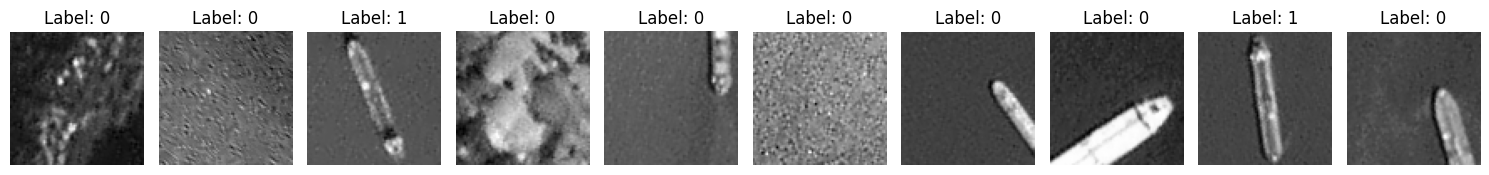

2916


100%|██████████| 2800/2800 [00:10<00:00, 270.55it/s]


Model saved to ./hog_model.pkl


100%|██████████| 1200/1200 [00:04<00:00, 267.63it/s]


              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       900
         1.0       0.99      0.97      0.98       300

    accuracy                           0.99      1200
   macro avg       0.99      0.98      0.99      1200
weighted avg       0.99      0.99      0.99      1200

Model loaded from ./hog_model.pkl
Before suppression, we had 38 bounding boxes, after suppression we have 19


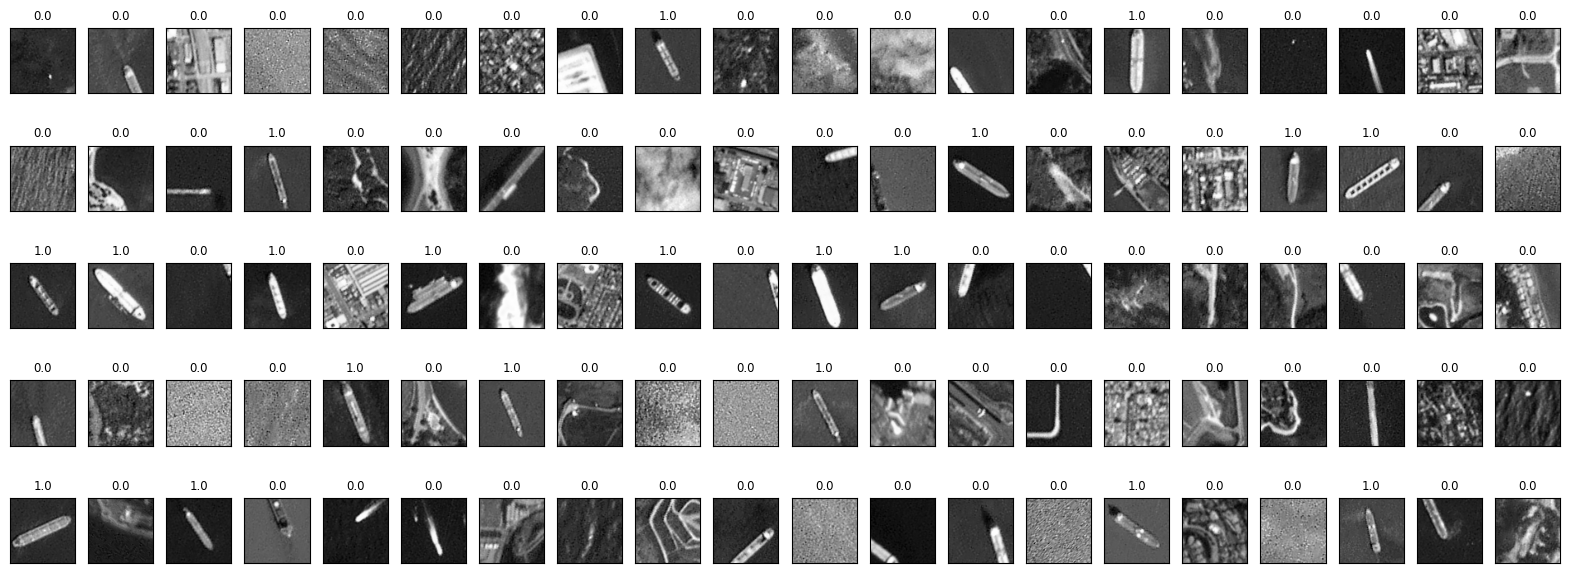

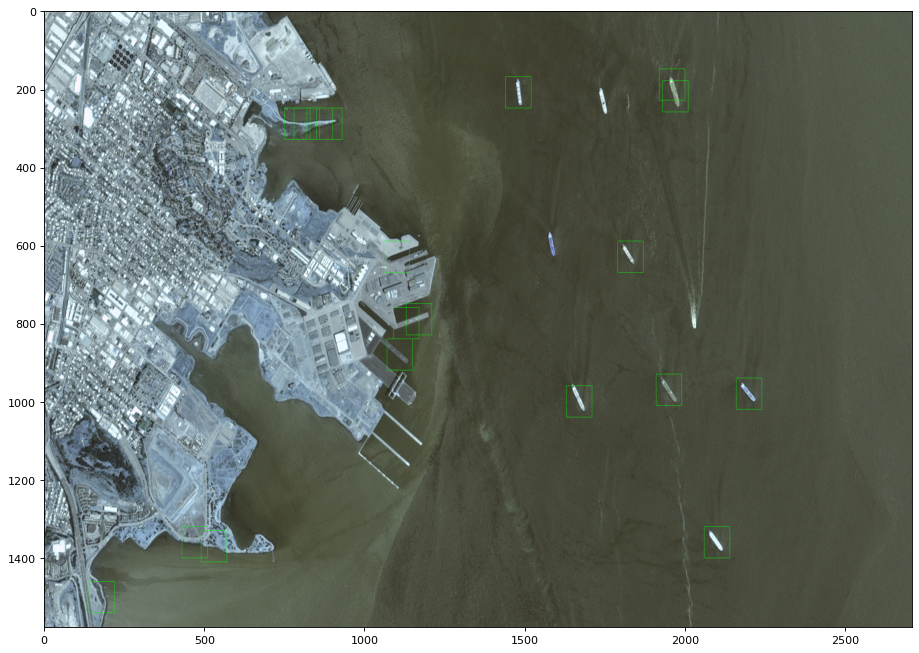

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
if __name__ == "__main__":

   #################################
   #  Prepare dataset
   #################################

   # Read downloaded file list: Files are comprised of positive (ship) and negaitive (Not ship) examples
   pos_img_list = glob.glob('shipsnet/shipsnet/1_*.png')
   neg_img_list = glob.glob('shipsnet/shipsnet/0_*.png')

   # Instantiate Datset from File Lists and plot example images
   dataset = ImageDataset(pos_img_list, neg_img_list)
   X_train, X_test, y_train, y_test = dataset.get_train_test_split()
   dataset.plot_examples(num_examples=10)

   #############################
   # Train & Test Patch Classifier
   ###############################

   #Initialise the Object Detector
   orientations = 9
   pixels_per_cell =8
   cells_per_block = 2
   patch_size = 80

   HOD = HogObjDet(orientations,pixels_per_cell,cells_per_block,patch_size)

   # Train the Classifier
   HOD.train_classifier(X_train,y_train)

   # Obtain a set of predictions
   y_pred = HOD.test_classifier(X_test)

   # Print a Classification Report
   print(classification_report(y_test, y_pred))

   # Visualise test examples
   dataset.plot_test_examples(X_test,y_test,y_pred)

   #############################################
   # Test Sliding Window Detector on Large Image
   ###############################################

   # Import Images
   img_path = 'scenes/scenes/sfbay_3.png'
   col_img = cv2.imread(img_path, cv2.IMREAD_COLOR)
   gray_img = cv2.cvtColor(col_img, cv2.COLOR_BGR2GRAY)
   #plt.imshow( gray_img ,'gray')

   # Call Sliding Window Detector
   found_boxes = HOD.sliding_window(gray_img,10)

   # Apply Non-maximal supression to remove overlapping boxes
   nmsBoundingBoxes = non_max_suppression(found_boxes, probs=None, overlapThresh=0.65)
   print ("Before suppression, we had {} bounding boxes, after suppression we have {}".format(len(found_boxes), len(nmsBoundingBoxes)))

   # Draw boxes on test Image
   dataset.plot_test_slidingwindow(col_img,nmsBoundingBoxes)

   ##############################
   # Download trained classifier
   ############################
   # Download your trained model before upload Comment this code before submission
   #from google.colab import files
   #files.download('hog_model.pkl')
